# **Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score, davies_bouldin_score
from google.colab import drive


# **Data Loading**

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

customers = pd.read_csv('/content/drive/MyDrive/Customers.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Transactions.csv')


# Merging data based on CustomerID
customer_transactions = pd.merge(customers, transactions, on="CustomerID")


# **K-Means Clustring**

Silhouette Score for k=6: 0.4273
Davies-Bouldin Index for k=6: 0.9367


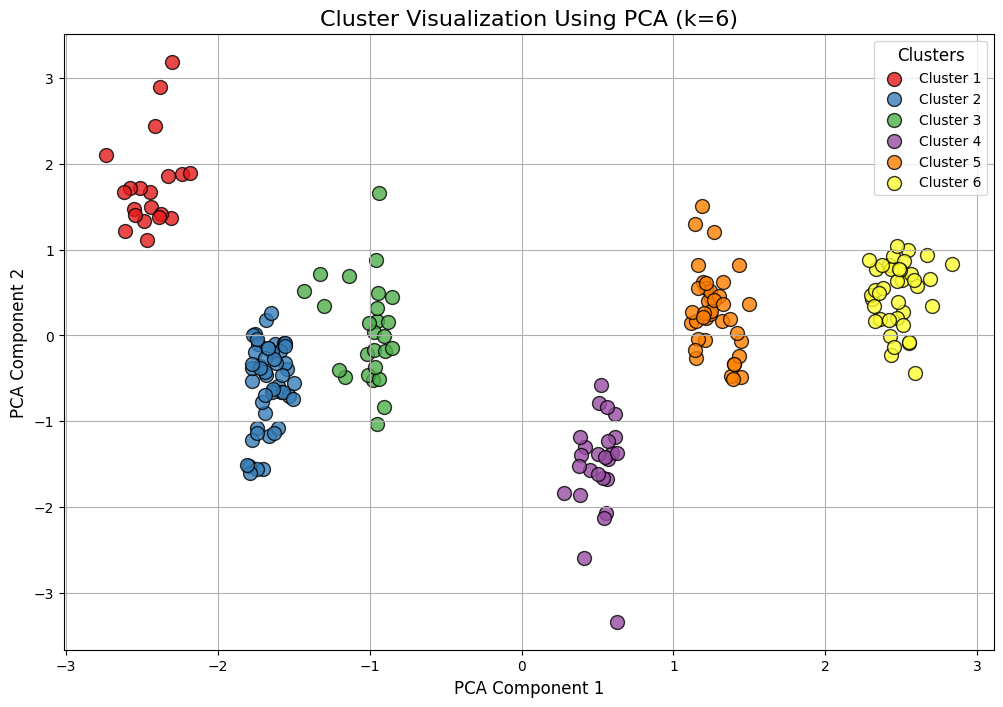

In [6]:
# Merging customer and transaction data
customer_transactions = pd.merge(customers, transactions, on="CustomerID")

# Aggregate data for each customer
customer_features = customer_transactions.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'Price': 'mean',
    'Region': 'first'
}).reset_index()

# Standardize numerical features for clustering
scaler = StandardScaler()
numeric_features = ['Quantity', 'Price']
customer_features[numeric_features] = scaler.fit_transform(customer_features[numeric_features])

# Encode categorical features (Region)
customer_features = pd.get_dummies(customer_features, columns=['Region'])

# Set k for clustering
k = 6

# Applying KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features[numeric_features + list(customer_features.columns[4:])])

customer_features['Cluster'] = customer_features['Cluster'] + 1

# Calculating clustering metrics
silhouette = silhouette_score(customer_features[numeric_features + list(customer_features.columns[4:])], customer_features['Cluster'])
db_index = davies_bouldin_score(customer_features[numeric_features + list(customer_features.columns[4:])], customer_features['Cluster'])

print(f"Silhouette Score for k={k}: {round(silhouette, 4)}")
print(f"Davies-Bouldin Index for k={k}: {round(db_index, 4)}")

# Performing PCA for better clustering visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(customer_features[numeric_features + list(customer_features.columns[4:])])

plt.figure(figsize=(12, 8))

feature_x = pca_features[:, 0]
feature_y = pca_features[:, 1]

# Creating a scatter plot with different colors for each cluster
sns.set_palette("Set1")
for cluster in range(1, k + 1):
    cluster_data = customer_features[customer_features['Cluster'] == cluster]
    plt.scatter(
        feature_x[customer_features['Cluster'] == cluster],
        feature_y[customer_features['Cluster'] == cluster],
        label=f"Cluster {cluster}",
        alpha=0.8,
        s=100,
        edgecolors='black'
    )

plt.title(f"Cluster Visualization Using PCA (k={k})", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)

plt.legend(title="Clusters", fontsize=10, title_fontsize=12)

plt.grid(True)
plt.show()


# **Cluster Analysis**

In [7]:
cluster_analysis = customer_features.groupby('Cluster').agg({
    'Quantity': 'mean',
    'Price': 'mean',

}).reset_index()

# Calculating the most common region per cluster
region_columns = [col for col in customer_features.columns if col.startswith('Region_')]
customer_features['CommonRegion'] = customer_features[region_columns].idxmax(axis=1).str.replace('Region_', '')

# Adding the most common region for each cluster
cluster_analysis['CommonRegion'] = customer_features.groupby('Cluster')['CommonRegion'].first()

print(cluster_analysis)


   Cluster  Quantity     Price   CommonRegion
0        1  1.735980 -0.551812            NaN
1        2 -0.568608  0.204994  South America
2        3 -1.012174 -1.459369  South America
3        4 -0.702255  1.620537         Europe
4        5  0.024234 -0.458655           Asia
5        6  0.939450  0.412930           Asia


# **Cluster Analysis Explanation**
**Cluster 1:** Customers with slightly below-average spending and low purchase quantities. These customers might be occasional buyers or less engaged.

**Cluster 2:** Customers with higher-than-average spending and purchases, predominantly from South America. These could be moderately loyal customers worth nurturing.

**Cluster 3:** This group, also from South America, shows high engagement with above-average spending and purchases. These are likely your more profitable customers.

**Cluster 4:** Customers from South America with low engagement and low spending. They could be newer customers who haven’t developed strong purchasing habits yet.

**Cluster 5:** Customers from Asia with below-average spending and fewer purchases. These might be less engaged and need more attention to increase loyalty.

**Cluster 6:** Customers from Asia showing relatively high spending but low purchases. They could be loyal customers who have been around for a while, showing potential for consistent engagement.

### **Actionable Insights**

**High-Value Customers (Cluster 3):**
- Focus on retention with exclusive rewards and loyalty programs.

**Moderately Engaged Customers (Cluster 2):**
- Boost engagement with targeted promotions and premium offers.

**Inactive Customers (Cluster 1 & 6):**
- Run re-engagement campaigns with personalized offers and discounts.

**New or Emerging Customers (Cluster 4 & 5):**
- Use onboarding campaigns and incentives to drive initial engagement.

**Loyal Customers (Cluster 5):**
- Reward loyalty with VIP perks and early access to products.